In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from data_process.shadow_render import render_shadow
import matplotlib.pyplot as plt

import torch
from ssn import ssn_dataset
from torchvision import transforms, utils
import numpy as np
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Testing relative vectors

In [3]:
# generate ibls(rotating around)
def to_mask(img):
    img = (img[:,:,0] + img[:,:,1] + img[:,:,2])/3.0
    img = img/np.max(img)
    return img

# relative_vec = np.array([0.108, 2.64, 1.8])
# ibl_img = to_mask(render_shadow(relative_vec))

# Render predictions  

norm: group_norm bilinear: True activation: prelu
Device:  cuda:0
float64
uint8
[255 255 255 ... 255 255 255]
255


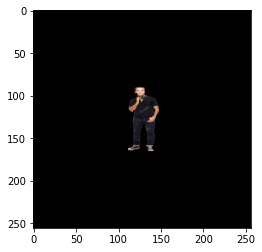

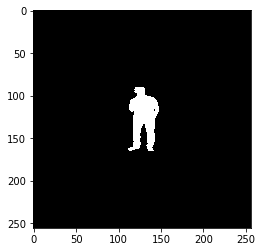

In [4]:
from tqdm import tqdm
from PIL import Image
from ssn.ssn_dataset import Mask_Transform, IBL_Transform, ToTensor
import os 
import random
from scipy.ndimage.filters import gaussian_filter
from valid_relight_ssn import predict, compute_ibl, merge_result
from skimage.transform import resize

def show_np(img, cmap='gray', title=''):
    plt.figure()
    plt.title(title)
    plt.imshow(np.squeeze(img), cmap=cmap)
    
def to_one_batch(img_tensor):
    c,h,w = img_tensor.size()
    return img_tensor.view(1,c,h,w)

def to_numpy(one_batch):
    return one_batch[0].detach().cpu().numpy().transpose((1,2,0))

def png_to_3channel(img):
    """ mask image from 4 channel png to 3 channel"""
    h,w,c = img.shape
    if c != 4:
        print("image is not 4 channel")
        return img
    
    out_img, alpha = img[:,:,0:3]/255.0, img[:,:,3]/255.0
    out_img[:,:,0] = out_img[:,:,0] * alpha
    out_img[:,:,1] = out_img[:,:,1] * alpha
    out_img[:,:,2] = out_img[:,:,2] * alpha
    out_img = out_img * 255.9
    out_img = out_img.astype(np.uint8)
    return out_img

def padding_image(img, padding_size):
    """ padding an image with a padding size """
    if padding_size == 0:
        return img
    
    h, w = img.shape[:2]
    if len(img.shape) == 2:
        c = 1
    else:
        c = img.shape[-1]
    
    img = img.reshape((h,w,c))
    out_img = np.zeros((h + 2 * padding_size, w + 2 * padding_size, c),dtype=np.float64)
    out_img[padding_size:padding_size + h, padding_size:padding_size+w, 0:c] = img[:,:,0:c]
    return out_img

def real_to_mask(img, unpadded_size=80):
    mask = img[:,:,-1]
    img = png_to_3channel(img)
    
    resize_w = unpadded_size
    img = resize(img, (resize_w, resize_w))
    img = padding_image(np.array(img), (256 - resize_w)//2)
    mask = resize(mask, (resize_w,resize_w))
    mask = padding_image(mask, (256 - resize_w)//2)
    
    thresh_hold = 0.3
    mask[np.where(mask < thresh_hold)] = 0.0
    mask[np.where(mask >= thresh_hold)] = 1.0
    
    mask = np.squeeze((mask * 255.9).astype(np.uint8))
    mask = np.array([mask,] * 3).transpose((1,2,0))
    
    return img, mask

def synthetic_to_mask(img):
    img = img[:,:,0:3]
    img = resize(img, (256,256))

    h,w,c = img.shape
    mask = np.zeros((h,w,3), dtype=np.uint8)
    mask[np.where(img != 0)] = 255
    return img, mask

testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'
testing_img = Image.open(testing_fname)
testing_img, testing_mask_img = real_to_mask(np.array(testing_img))
show_np(testing_img)
show_np(testing_mask_img)

print(testing_img.dtype)
print(testing_mask_img.dtype)
print(testing_mask_img[np.where(testing_mask_img!=0)])
print(np.max(testing_mask_img))

0.8952941176470589
255
(256, 256, 3)
shadow shape:(256, 256, 1) min: 5.495310233527562e-06, max: 18.72999382019043
0.96281045751634
255
(256, 256, 3)
shadow shape:(256, 256, 1) min: 5.560057729780965e-07, max: 18.729976654052734
0.9896172839506178
255
(256, 256, 3)
shadow shape:(256, 256, 1) min: 1.7279677422266104e-06, max: 18.729970932006836
0.9913725490196075
255
(256, 256, 3)
shadow shape:(256, 256, 1) min: 3.1577915251546074e-06, max: 18.729961395263672
0.9921568627450981
255
(256, 256, 3)
shadow shape:(256, 256, 1) min: 4.467679900699295e-06, max: 18.72989845275879


/home/ysheng/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


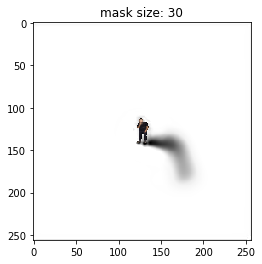

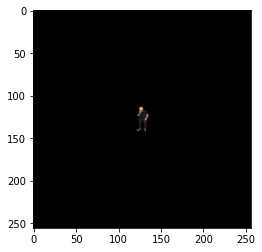

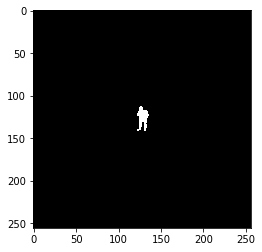

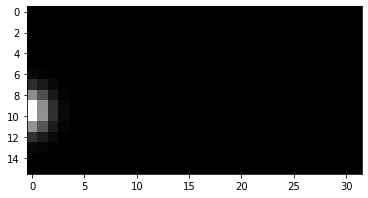

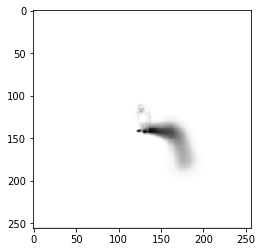

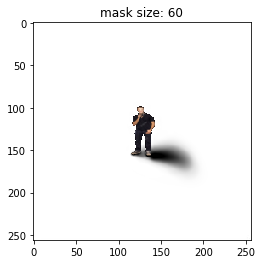

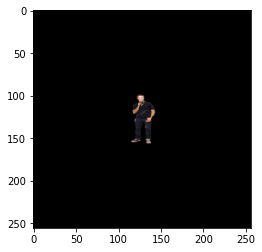

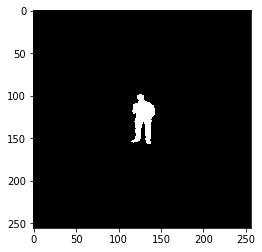

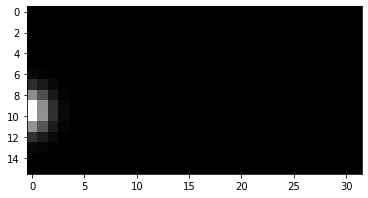

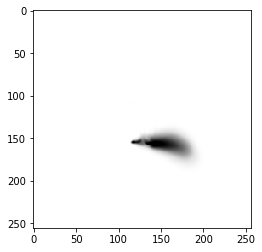

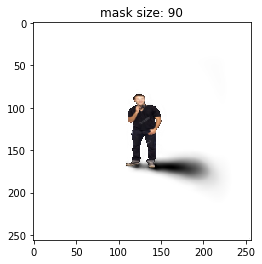

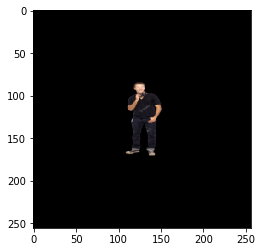

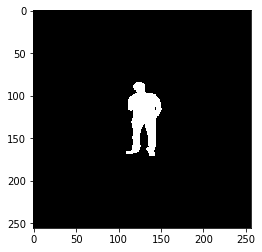

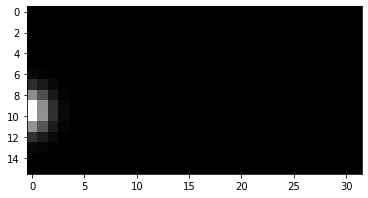

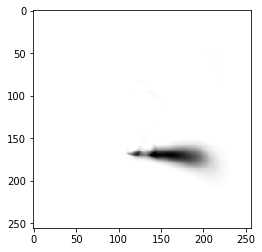

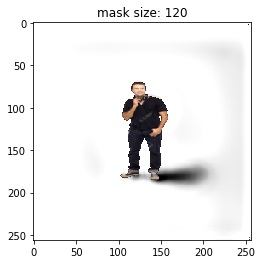

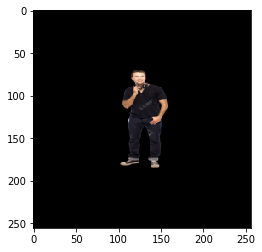

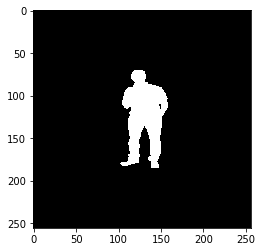

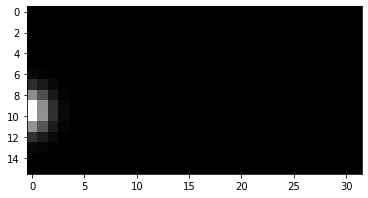

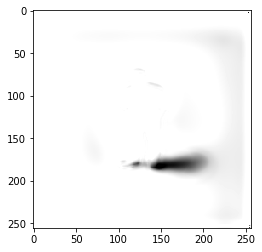

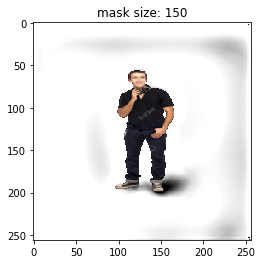

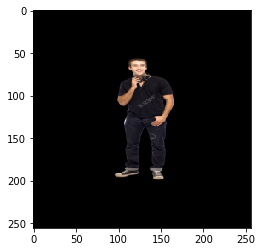

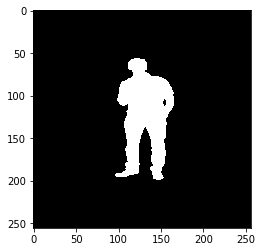

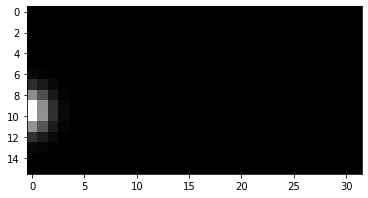

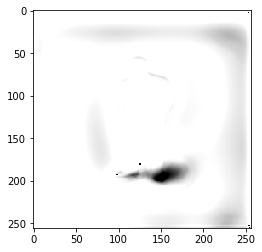

In [5]:
def predict_real_result(test_fname, mask_size,testing_ibl):
    testing_img = np.array(Image.open(test_fname))
    testing_img, testing_mask = real_to_mask(np.array(testing_img), mask_size)

    print(np.max(testing_img))
    print(np.max(testing_mask))
    print(testing_mask.shape)

    shadow = predict(testing_mask, testing_ibl)
    print('shadow shape:{} min: {}, max: {}'.format(shadow.shape,np.min(shadow),np.max(shadow)))
    shadow = np.clip(shadow, 0.0, 1.0)

    shadow_result = merge_result(testing_img, testing_mask, shadow)

    show_np(shadow_result, title='mask size: {}'.format(mask_size))
    plt.savefig('{}.png'.format(mask_size))
    show_np(testing_img)
    show_np(testing_mask)
    show_np(np.squeeze(testing_ibl))
    show_np(np.squeeze(shadow), 'gray')

testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'
testing_ibl = compute_ibl(0, 160)

predict_real_result(testing_fname, 30,testing_ibl)
predict_real_result(testing_fname, 60,testing_ibl)
predict_real_result(testing_fname, 90,testing_ibl)
predict_real_result(testing_fname, 120,testing_ibl)
predict_real_result(testing_fname, 150,testing_ibl)


# Make animations

  0%|          | 0/2048 [00:00<?, ?it/s]

(256, 256, 3)
(256, 256, 3)
mask max: 255


  0%|          | 1/2048 [00:00<04:02,  8.45it/s]

(256, 256, 3)
(256, 256, 3)
mask max: 255


  0%|          | 1/2048 [00:00<04:05,  8.33it/s]

(256, 256, 3)
(256, 256, 3)
mask max: 255


100%|██████████| 2048/2048 [02:53<00:00, 11.78it/s]


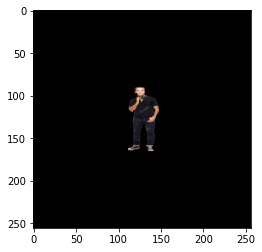

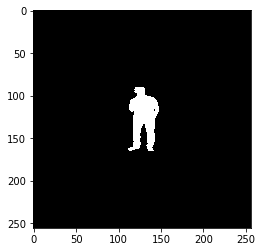

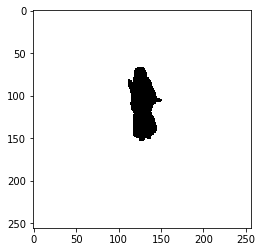

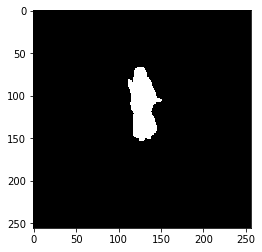

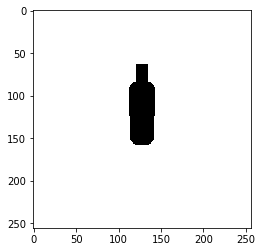

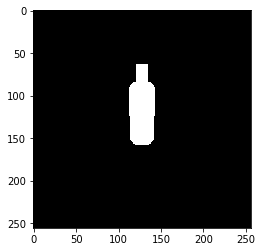

In [6]:
from valid_relight_ssn import render_animation
import numpy as np
from PIL import Image

def delete_old_imgs(folder):
    import os
    import glob

    files = glob.glob(folder + "/*.*")
    for f in files:
        if os.path.isfile(f):
            os.remove(f)

def animate_real_data(file_path, out_folder):
    testing_img = Image.open(file_path)
    testing_img, testing_mask = real_to_mask(np.array(testing_img))

    show_np(testing_img)
    show_np(testing_mask)

    os.makedirs(out_folder, exist_ok=True)
    delete_old_imgs(out_folder)
    print(testing_img.shape)
    print(testing_mask.shape)
    print('mask max: {}'.format(np.max(testing_mask)))

    render_animation(testing_img, testing_mask, out_folder, 3)

def animate_syn_data(file_path, out_folder):
    testing_img = np.array(Image.open(file_path))
    os.makedirs(out_folder, exist_ok=True)
    delete_old_imgs(out_folder)

    testing_img, testing_mask = synthetic_to_mask(testing_img)
    testing_img = (255-testing_mask)/255.0
    print(testing_img.shape)
    print(testing_mask.shape)
    print('mask max: {}'.format(np.max(testing_mask)))
    show_np(testing_img)
    show_np(testing_mask)

    render_animation(testing_img, testing_mask, out_folder)
    

testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'
output_folder = 'results/animations/experiments'
animate_real_data(testing_fname, output_folder)

training_human = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_fullbody_bridget8_wildwind_ssradclosedrobe_Base_Pose_Standing_A/imgs/0000000_mask.png'
output_folder = 'results/animations/training_human_own_light'
animate_syn_data(training_human, output_folder)

training_bottle = '/home/ysheng/Dataset/soft_shadow/train/bottle_0052_normalize/imgs/0000000_mask.png'
output_folder = 'results/animations/training_simple_obj'
animate_syn_data(training_bottle, output_folder)

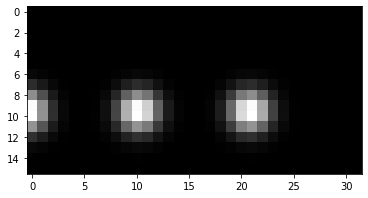

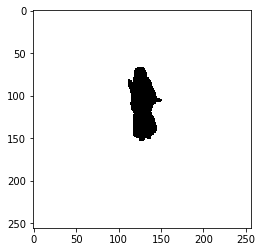

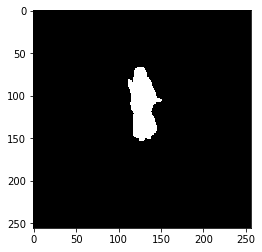

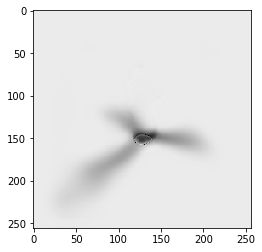

In [11]:
from valid_relight_ssn import compute_ibl, predict
    
training_human = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_fullbody_bridget8_wildwind_ssradclosedrobe_Base_Pose_Standing_A/imgs/0000000_mask.png'
ibl = compute_ibl(0, 160)
ibl += compute_ibl(512//3, 160)
ibl += compute_ibl(512//3 * 2, 160)

show_np(ibl)
testing_img = np.array(Image.open(training_human))
testing_img, testing_mask = synthetic_to_mask(testing_img)
testing_img = (255-testing_mask)/255.0
show_np(testing_img)
show_np(testing_mask)

predicted = predict(testing_mask, ibl)

# plt.figure()
# plt.imshow(pre)

# animate_syn_data(training_human, output_folder)

min: 0.010737664997577667, max: 1.0912799835205078


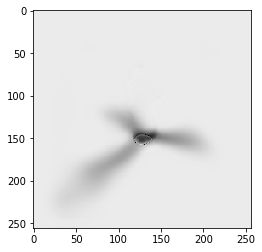

In [16]:
predicted = predicted/3.0
print('min: {}, max: {}'.format(np.min(predicted), np.max(predicted)))
plt.figure()
plt.imshow(np.squeeze(predicted), cmap='gray', )
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 1)
input: (256, 256, 3) 
after transpose: (3, 256, 256) 
after shuffling: (3, 256, 256) 
after transpose: (256, 256, 3) 


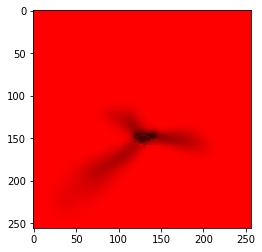

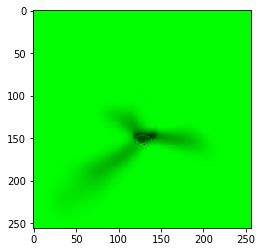

In [37]:
print(predicted.shape)
h,w,c = predicted.shape
out = np.zeros((h,w,3), dtype=predicted.dtype)
out[:,:,0] = np.squeeze(predicted)

show_np(out)

print('input: {} '.format(out.shape))

out = np.transpose(out,(2,0,1))
print('after transpose: {} '.format(out.shape))

np.random.shuffle(out)
print('after shuffling: {} '.format(out.shape))

out = np.transpose(out, (1,2,0))
print('after transpose: {} '.format(out.shape))

show_np(out)